In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def Norm(m: np.ndarray) -> np.float32:
    if len(m.shape) == 1:
        tmp = 0
        mx = np.abs(m[0])
        for i in range(m.shape[0]):
            if np.abs(m[i]) > mx:
                mx = np.abs(m[i])
        return mx
    mx = 0
    for i in range(m.shape[0]):
        tmp = 0
        for j in range(m.shape[0]):
            tmp += np.abs(m[i][j])
        if tmp > mx:
            mx = tmp
    return mx

In [3]:
def LU_dec(A: np.ndarray) -> tuple:
    L = np.empty(A.shape, np.float64)
    U = np.empty(A.shape, np.float64)
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            U[i, j] = A[i, j]
            L[i, j] = int(i == j)
    for i in range(n):
        for j in range(i+1, n):
            L[j, i] = U[j, i] / U[i, i]
            U[j] = U[j] - L[j, i] * U[i]
    return (L, U)

In [4]:
def swap(A: np.ndarray, L: np.ndarray, permutations: list, i: int):
    mx, line = np.abs(A[i, i]), i
    for j in range(i+1, A.shape[0]):
        if np.abs(A[j, i]) > mx:
            mx = np.abs(A[j, i])
            line = j
    for j in range(A.shape[0]):
        A[line, j], A[i, j] = A[i, j], A[line, j]
        L[line, j], L[i, j] = L[i, j], L[line, j]
    permutations[i], permutations[line] = permutations[line], permutations[i]

def LU_part(A: np.ndarray) -> tuple:
    L = np.empty(A.shape, np.float64)
    n = A.shape[0]
    permutations = list(range(n))
    for i in range(n):
        for j in range(n):
            L[i, j] = int(i == j)
    for i in range(n):
        swap(A, L, permutations, i)
        for j in range(i+1, n):
            L[j, i] = A[j, i] / A[i, i]
            A[j] = A[j] - L[j, i] * A[i]
    return L, permutations

In [5]:
def Solve(L: np.ndarray, U: np.ndarray, b: np.ndarray, perm=[]) -> np.ndarray:
    x = np.zeros_like(b, np.float64)
    if not perm:
        perm = list(range(L.shape[0]))
    for i in range(b.shape[0]):
        x[i] = b[perm[i]]
    for i in range(1, L.shape[0]):
        for j in range(i):
            x[i]-= x[j] * L[i, j]    
    for i in range(L.shape[0]-1, -1, -1):
        for j in range(i+1, L.shape[0]):
            x[i]-= x[j] * U[i, j]
        x[i] /= U[i, i]
    return x

In [6]:
def get_matrix(n: int) -> np.ndarray:
    f0 = lambda i, j: np.tan(i + 1)**(17 - j)
    f1 = lambda i, j: 1 / (70 - 3*i - j)
    f2 = lambda i, j: np.sin(i + 1) ** (20 - j)
    f3 = lambda i, j: np.arctan(0.1*(10*i + j + 1))
    A = np.array([[f0(i, j) for j in range(n)] for i in range(n)], np.float64)
    return A

In [7]:
#Возмущенная матрица обычной декомпозицией
A = get_matrix(5)
x = np.array([33.] * 5, np.float64)
A_ = get_matrix(5)
A_[0, 0] += 1e-3
b = A.dot(np.array([33 for _ in range(5)], np.float64))
L, U = LU_dec(A_)
x1 = Solve(L, U, b)
print(x1)
print(A_.dot(x1) - b)

[32.99999171 32.99996228 32.99998698 33.00006978 33.00001011]
[ 0.00000000e+00 -1.86264515e-09  1.03397577e-25 -1.13686838e-12
 -3.81469727e-06]


In [8]:
#Возмущенная матрица по схеме частичного выбора
L, perm = LU_part(A_)
x2 = Solve(L, A_, b, perm)
A_ = get_matrix(5); A_[0, 0] += 1e-3
print(x2)
print(A_.dot(x2) - b)

[32.99999171 32.99996228 32.99998698 33.00006978 33.00001011]
[ 0.00000000e+00 -3.72529030e-09 -5.16987883e-26  0.00000000e+00
  0.00000000e+00]


In [9]:
A = get_matrix(5)
nu_b = Norm(A) * Norm(np.linalg.inv(A))
d_x = Norm(x - x1) / Norm(x1)
d_A = Norm(A_ - A) / Norm(A)

In [10]:
nu_b, d_x, d_A

(1.2651682308961201e+20, 2.1145934941980693e-06, 7.177350076381855e-13)

In [11]:
d_x, nu_b * d_A

(2.1145934941980693e-06, 90805552.98658165)

In [12]:
def get_error1(n: int, eps: np.float64) -> np.float64:
    A = get_matrix(n)
    b = A.dot(np.array([33 for _ in range(n)], np.float64))
    L, U = LU_dec(A)
    x = Solve(L, U, b)
    A[0, 0] += eps
    L, U = LU_dec(A)
    x_ = Solve(L, U, b)
    return Norm(x - x_)/Norm(x_)

In [13]:
def get_error2(n: int, eps: np.float64) -> np.float64:
    A = get_matrix(n)
    b = A.dot(np.array([33 for _ in range(n)], np.float64))
    L, perm = LU_part(A)
    x = Solve(L, A, b, perm)
    A_ = get_matrix(n); A_[0, 0] += eps
    L, perm = LU_part(A_)
    x_ = Solve(L, A_, b, perm)
    return Norm(x - x_)/Norm(x_)

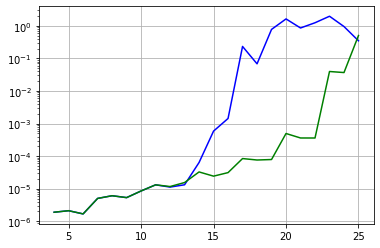

In [18]:
fig, axs = plt.subplots()

x_data = list(range(4, 26))
eps = 1e-3
axs.plot(x_data, [get_error1(i, eps) for i in x_data], color="blue")
axs.plot(x_data, [get_error2(i, eps) for i in x_data], color="green")
ax = plt.gca()
plt.yscale('log')
# plot X - axis    
ax.axhline(y=0, color='k')
axs.grid(True)
#fig.savefig("3.1_plot.png", dpi=500)

In [15]:
m = np.array([[5., 0., 4.9], [0., 4.9, 0.], [4.9, 0., 8.1634]], np.float64)
b = np.array([20.9, -2.03, 12.985], np.float64)
L, U = LU_dec(m)
x = Solve(L, U, b)
print(x)

[ 6.36571429 -0.41428571 -2.2303207 ]


In [16]:
P_1 = lambda x: 4.18 + 0.414*x
P_2 = lambda x: 6.366 - 0.414*x-2.230*x**2
arg = [-1.4, -0.7, 0, 0.7, 1.4]
f = [2.5, 5.4, 7.3, 3.9, 1.8]
print((0.2 * sum([(P_2(arg[i]) - f[i])**2 for i in range(5)]))**0.5)

0.6672762935995855


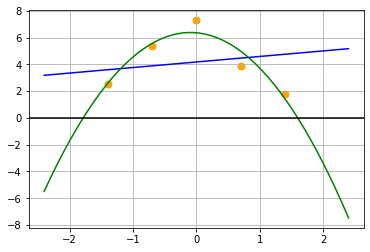

In [17]:
fig, axs = plt.subplots()

x_data = np.linspace(arg[0]-1, arg[-1]+1)
axs.plot(x_data, P_1(x_data) , color="blue")
axs.plot(x_data, P_2(x_data), color="green")
for i in range(5):
    axs.plot(arg[i], f[i], color="black")
    plt.scatter(arg, f, color='orange', s=40, marker='o')
ax = plt.gca()
# plot X - axis    
ax.axhline(y=0, color='k')
axs.grid(True)
#fig.savefig("reqular_calc_13.png", dpi=500)